## **King County House Price Prediction using MultiLinear Regression**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import IPython.display
%cd '/content/drive/MyDrive/KC_Prices/'

This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

The meaning of some selected variables.

* id: a notation for a house
* date: the date house was sold
* price: price of the house
* bedrooms: number of bedrooms
* bathrooms: number of bathrooms/bedrooms
* sqftliving: square footage of the home
* zipcode: zip code
* condition: how good the condition is overall. 1 indicates worn out property and 5 excellent.

In [ ]:
dataset = pd.read_csv("kc_house_data.csv")
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Find how many covariate variables? How many samples?

In [ ]:
dataset.shape
#there are 19 covariate variables and 21613 samples

(21613, 21)

 Creating a new dataframe with the target variable `price` and the following covariates: `bedrooms`, `bathrooms`, `sqft_living`, `zipcode`,`condition`. Converting `price` to be in terms of 1000s of dollars, i.e.  price = price/1000.

In [ ]:
#let df be the dataset with only the above covariates
df = dataset[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'zipcode', 'condition']]
#divide the price column by 1000
df['price'] = df['price'] / 1000
df

,price,bedrooms,bathrooms,sqft_living,zipcode,condition
0,221.900,3,1.00,1180,98178,3
1,538.000,3,2.25,2570,98125,3
2,180.000,2,1.00,770,98028,3
3,604.000,4,3.00,1960,98136,5
4,510.000,3,2.00,1680,98074,3
...,...,...,...,...,...,...
21608,360.000,3,2.50,1530,98103,3
21609,400.000,4,2.50,2310,98146,3
21610,402.101,2,0.75,1020,98144,3
21611,400.000,3,2.50,1600,98027,3


For each categorical variable, print out the number of categories.

In [ ]:
print(df['bedrooms'].nunique())
print(df['bathrooms'].nunique())
print(df['zipcode'].nunique())
print(df['condition'].nunique())

13
30
70
5


A covariance matrix between all variables (including price) and a pair plot

In [ ]:
# covariance
print(df.cov())

                     price    bedrooms   bathrooms    sqft_living  \
price        134782.378397  105.286276  148.481496  236715.431307   
bedrooms        105.286276    0.865015    0.369527     492.596040   
bathrooms       148.481496    0.369527    0.593151     533.811988   
sqft_living  236715.431307  492.596040  533.811988  843533.681368   
zipcode       -1045.071663   -7.597239   -8.400840   -9800.232484   
condition         8.687030    0.017232   -0.062638     -35.114601   

                 zipcode  condition  
price       -1045.071663   8.687030  
bedrooms       -7.597239   0.017232  
bathrooms      -8.400840  -0.062638  
sqft_living -9800.232484 -35.114601  
zipcode      2862.787835   0.105343  
condition       0.105343   0.423467  


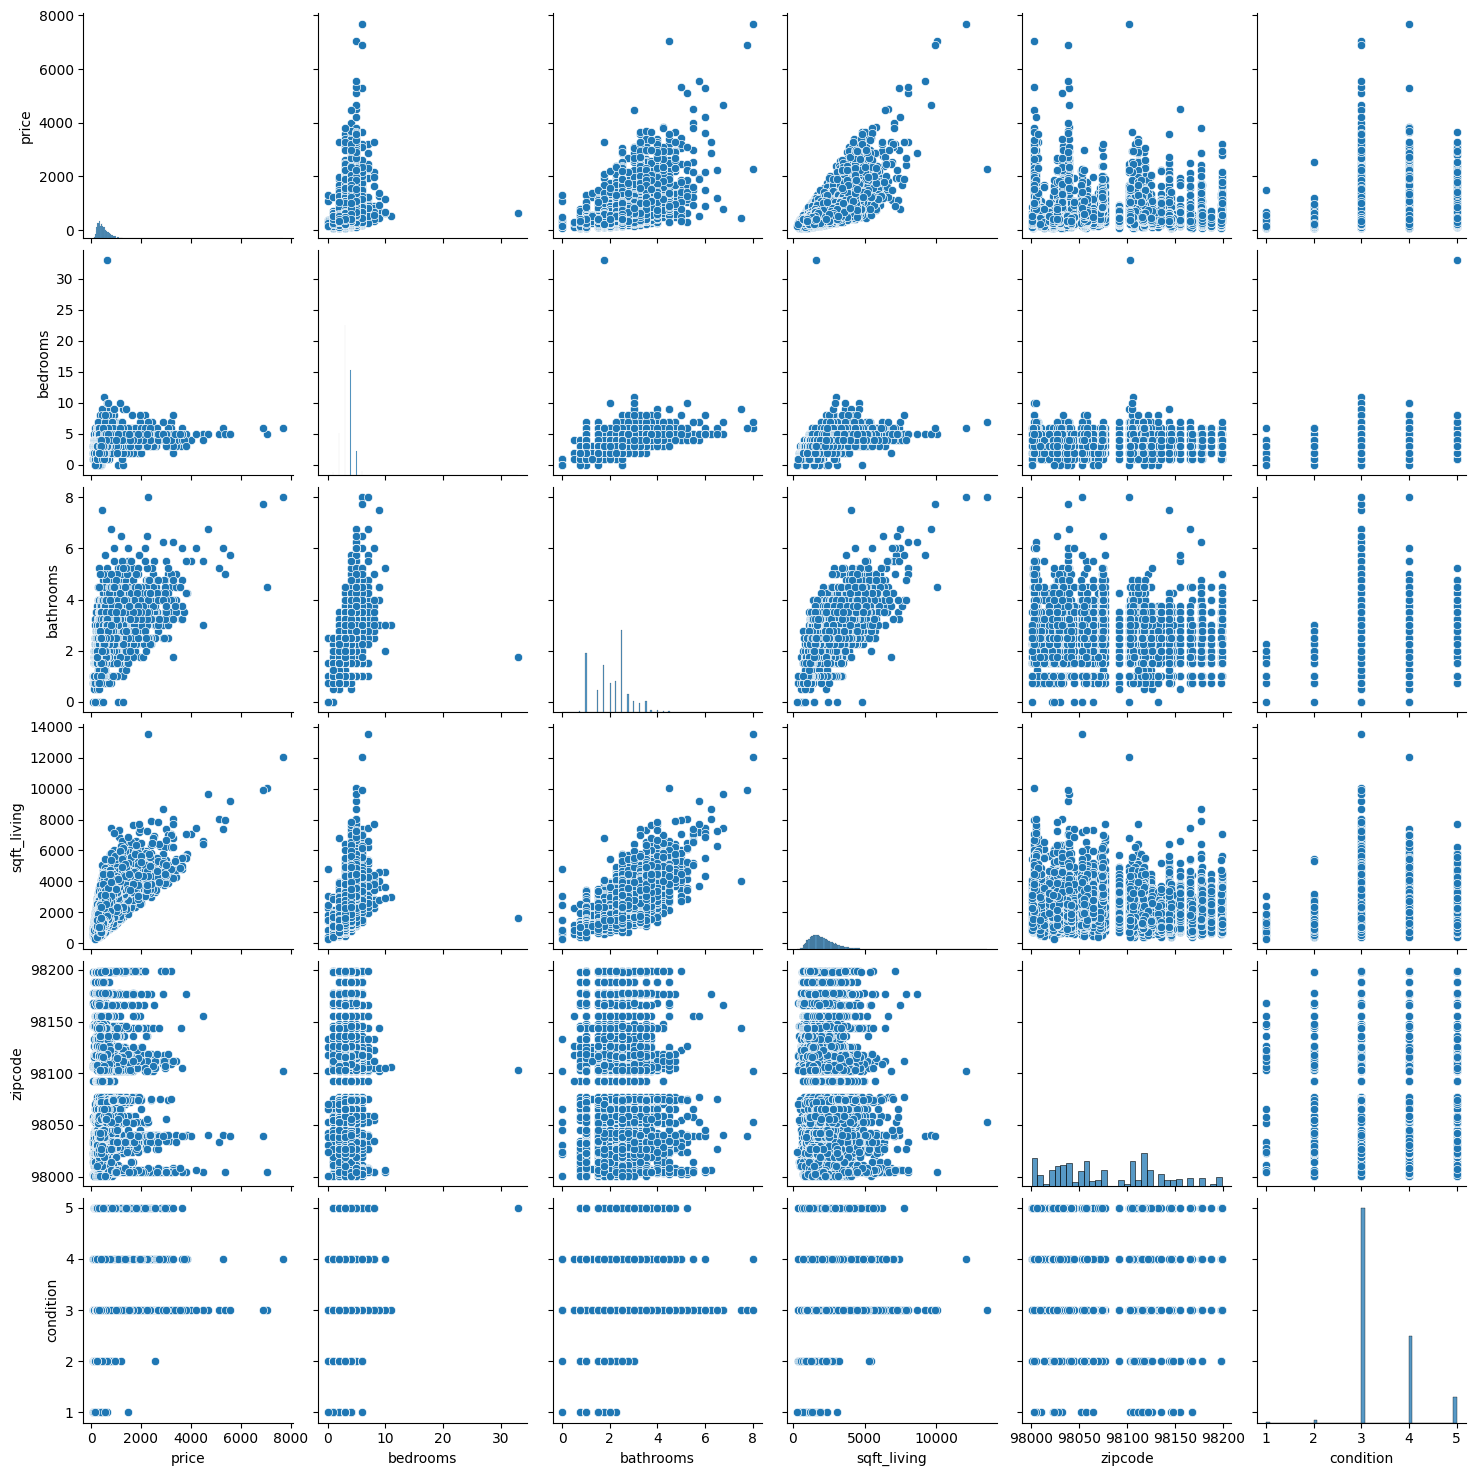

In [ ]:
# pair plot
sns.pairplot(df)
plt.show()
#from the pairplot, it seems that bedrooms is most correlated with price, and zipcode is the least correlated.

## **Building the model**

In [ ]:
dataset = pd.read_csv("kc_house_data.csv")
dataset = dataset.drop(['id', 'date'], axis=1)
dataset.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
for col in cols:
  print(f'{col}: {dataset[col].nunique()}')

bedrooms: 13
bathrooms: 30
sqft_living: 1038
sqft_lot: 9782
floors: 6
waterfront: 2
view: 5
condition: 5
grade: 12
sqft_above: 946
sqft_basement: 306
yr_built: 116
yr_renovated: 70
zipcode: 70
lat: 5034
long: 752
sqft_living15: 777
sqft_lot15: 8689


In [ ]:
from sklearn.preprocessing import OneHotEncoder

def refineArea(x):
  if x <= 98050:
    return 0
  elif x > 98050 and x <= 98100:
    return 1
  elif x > 98100 and x <= 98150:
    return 2
  elif x > 98150:
    return 3

y = dataset.loc[:,['price']] / 1000
features = dataset.drop('price', axis=1)
# sns.pairplot(features)
# plt.show()
features['area2'] = features['zipcode'].map(refineArea)
# predict price/1000

# select continuous features
x_cont = features.loc[:,['sqft_living', 'sqft_lot', 'sqft_above','yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15','lat']]

# encode categorical features
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
x_cat =(features.loc[:,['bedrooms','floors','condition','waterfront', 'view', 'grade','zipcode']])
enc.fit(x_cat)
x_cat = enc.transform(x_cat)

# create interaction features
features['bedrooms_sqft_lot'] = features['bedrooms'] * features['sqft_lot']
features['bathrooms_sqft_living'] = features['bathrooms'] * features['sqft_living']
features['bathrooms_grade'] = features['bathrooms'] * features['grade']
features['yr_renovated_area2'] = features['yr_renovated'] * features['area2']
features['area2_sqft_living15'] = features['area2'] * features['sqft_living15']
features['sqft_above_sqft_living'] = features['sqft_above'] * features['sqft_living']
features['area2_lat'] = features['area2'] * features['lat']
features['area2_long'] = features['area2'] * features['long']
#features['bathrooms_sqft_lot'] = features['bathrooms'] * features['sqft_lot']

x_inter = features.loc[:,['bedrooms_sqft_lot', 'bathrooms_grade', 'yr_renovated_area2','bathrooms_sqft_living', 'area2_sqft_living15','sqft_above_sqft_living', 'area2_lat', 'area2_long']]
# concatenate all features into a single covariate array x
x = np.concatenate([x_cont, x_cat,x_inter], axis=1)
print(x.shape)


# you must use this split
x_train4, x_test4, y_train4, y_test4 = train_test_split(x, y, test_size=0.33, random_state=42)
#x_train4, x_test4, y_train4, y_test4 = train_test_split(dataset.loc[:,dataset.columns != 'price'], y, test_size=0.33, random_state=42)

(21613, 129)


In [ ]:
x_train4 = np.array(x_train4)
y_train4 = np.array(y_train4)
x_test4 = np.array(x_test4)
y_test4 = np.array(y_test4)

lm4 = LinearRegression()
lm4.fit(x_train4, y_train4)

yhat_train4 = lm4.predict(x_train4)
yhat_test4 = lm4.predict(x_test4)
print("Train")
print('MSE -', np.mean((y_train4 - yhat_train4)**2))
print('R2 - ', lm4.score(x_train4, y_train4))

print("\n")

print("Test")
print('MSE -', np.mean((y_test4 - yhat_test4)**2))
print('R2 - ', lm4.score(x_test4, y_test4))

Train
MSE - 18439.959700656327
R2 -  0.8552514151470112


Test
MSE - 26633.532492538663
R2 -  0.822124569404995


In [ ]:
x_train4constant = sm.add_constant(x_train4)
est4 = sm.OLS(y_train4, x_train4constant).fit()
print(est4.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     701.1
Date:                Fri, 18 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:27:14   Log-Likelihood:                -91660.
No. Observations:               14480   AIC:                         1.836e+05
Df Residuals:                   14358   BIC:                         1.845e+05
Df Model:                         121                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1571.2119   3452.191     -0.455      0.6